In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
file_path = "C:/Users/sharv/Downloads/wind_turbine.csv"
df = pd.read_csv(file_path)
df.head()

,unitlocation,ttimestamplocal,windspeed,power,wind direction Angle,rtr_rpm,pitch Angle,generation,wheel hub temperature,ambient Temperature,Tower bottom ambient temperature,failure time
0,WTG40,\t2020-03-01 00:00:00\t,0.93,0.0,0.0,0.38,49.99,2872434,10.54,2.78,19.40,11.12
1,WTG40,\t2020-03-01 00:10:00\t,0.81,0.0,0.0,0.37,49.99,2872434,10.60,2.80,19.08,11.12
2,WTG40,\t2020-03-01 00:20:00\t,0.56,0.0,0.0,0.36,49.99,2872434,10.92,2.76,19.34,11.12
3,WTG40,\t2020-03-01 00:30:00\t,0.46,0.0,0.0,0.36,49.99,2872434,10.65,2.72,19.32,11.12
4,WTG40,\t2020-03-01 00:40:00\t,0.45,0.0,0.0,0.33,49.99,2872434,10.62,2.82,19.19,11.12


In [3]:
# Add Fault Type Column with Improved Logic
df['Fault Type'] = "Normal"  # Default to Normal

# Overheating Fault: High hub temperature OR high ambient temperature
df.loc[(df['wheel hub temperature'] > 15) | (df['ambient Temperature'] > 10), 'Fault Type'] = "Overheating Fault"

# Rotor Fault: Low rotor speed under sufficient wind speed
df.loc[(df['rtr_rpm'] < 5) & (df['windspeed'] > 3), 'Fault Type'] = "Rotor Fault"

# Power Fault: Negative power output
df.loc[df['power'] < 0, 'Fault Type'] = "Power Fault"

# Combined Fault: High temperature + low rotor speed
df.loc[(df['wheel hub temperature'] > 15) & (df['rtr_rpm'] < 2), 'Fault Type'] = "Mechanical Fault"


In [4]:
output_file = "updated_dataset_with_faults.csv"
df.to_csv(output_file, index=False)

print(f"Updated dataset with Fault Type saved to {output_file}")

Updated dataset with Fault Type saved to updated_dataset_with_faults.csv


In [5]:
df.head()

,unitlocation,ttimestamplocal,windspeed,power,wind direction Angle,rtr_rpm,pitch Angle,generation,wheel hub temperature,ambient Temperature,Tower bottom ambient temperature,failure time,Fault Type
0,WTG40,\t2020-03-01 00:00:00\t,0.93,0.0,0.0,0.38,49.99,2872434,10.54,2.78,19.40,11.12,Normal
1,WTG40,\t2020-03-01 00:10:00\t,0.81,0.0,0.0,0.37,49.99,2872434,10.60,2.80,19.08,11.12,Normal
2,WTG40,\t2020-03-01 00:20:00\t,0.56,0.0,0.0,0.36,49.99,2872434,10.92,2.76,19.34,11.12,Normal
3,WTG40,\t2020-03-01 00:30:00\t,0.46,0.0,0.0,0.36,49.99,2872434,10.65,2.72,19.32,11.12,Normal
4,WTG40,\t2020-03-01 00:40:00\t,0.45,0.0,0.0,0.33,49.99,2872434,10.62,2.82,19.19,11.12,Normal


In [6]:
fault_counts = df['Fault Type'].value_counts()
print(fault_counts)

Fault Type
Overheating Fault    59167
Normal               14760
Mechanical Fault      8439
Power Fault           2568
Rotor Fault            132
Name: count, dtype: int64


In [7]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85066 entries, 0 to 85065
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   unitlocation                      85066 non-null  object 
 1   ttimestamplocal                   85066 non-null  object 
 2   windspeed                         85066 non-null  float64
 3   power                             85066 non-null  float64
 4   wind direction Angle              85066 non-null  float64
 5   rtr_rpm                           85066 non-null  float64
 6   pitch Angle                       85066 non-null  float64
 7   generation                        85066 non-null  int64  
 8   wheel hub temperature             85066 non-null  float64
 9   ambient Temperature               85066 non-null  float64
 10  Tower bottom ambient temperature  85066 non-null  float64
 11  failure time                      85066 non-null  float64
 12  Faul

## Data Preprocessing

In [8]:
df['ttimestamplocal'] = df['ttimestamplocal'].str.strip().str.replace(r'\\t', '', regex=True)
df['ttimestamplocal'] = pd.to_datetime(df['ttimestamplocal'])

print(df['ttimestamplocal'].head())

0   2020-03-01 00:00:00
1   2020-03-01 00:10:00
2   2020-03-01 00:20:00
3   2020-03-01 00:30:00
4   2020-03-01 00:40:00
Name: ttimestamplocal, dtype: datetime64[ns]


In [9]:
numerical_cols = ['windspeed', 'power', 'rtr_rpm', 'pitch Angle',
                  'wheel hub temperature', 'ambient Temperature',
                  'Tower bottom ambient temperature']

scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print(df[numerical_cols].describe())

          windspeed         power       rtr_rpm   pitch Angle  \
count  85066.000000  85066.000000  85066.000000  85066.000000   
mean       0.235005      0.313547      0.594504      0.091682   
std        0.136059      0.327594      0.302556      0.214145   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.134446      0.044485      0.402235      0.000659   
50%        0.218351      0.172304      0.592977      0.000879   
75%        0.319921      0.508563      0.861133      0.018122   
max        1.000000      1.000000      1.000000      1.000000   

       wheel hub temperature  ambient Temperature  \
count           85066.000000         85066.000000   
mean                0.652957             0.590012   
std                 0.191917             0.189078   
min                 0.000000             0.000000   
25%                 0.530157             0.469602   
50%                 0.677423             0.619067   
75%                 0.815536             0.

In [10]:
df['temperature_diff'] = df['wheel hub temperature'] - df['ambient Temperature']

df['power_to_wind_ratio'] = df['power'] / (df['windspeed'] + 1e-5)

In [11]:
df = pd.get_dummies(df, columns=['unitlocation'], drop_first=True)

label_encoder = LabelEncoder()
df['Fault Type'] = label_encoder.fit_transform(df['Fault Type'])

fault_type_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Fault Type Mapping:", fault_type_mapping)

Fault Type Mapping: {'Mechanical Fault': 0, 'Normal': 1, 'Overheating Fault': 2, 'Power Fault': 3, 'Rotor Fault': 4}


In [12]:
df['failure time'] = scaler.fit_transform(df[['failure time']])

df['failure_time_category'] = pd.cut(df['failure time'], bins=[0, 0.33, 0.66, 1], labels=['Short', 'Medium', 'Long'])

In [13]:
df.to_csv("preprocessed_dataset.csv", index=False)
print("Preprocessed dataset saved as preprocessed_dataset.csv")

Preprocessed dataset saved as preprocessed_dataset.csv


In [14]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85066 entries, 0 to 85065
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ttimestamplocal                   85066 non-null  datetime64[ns]
 1   windspeed                         85066 non-null  float64       
 2   power                             85066 non-null  float64       
 3   wind direction Angle              85066 non-null  float64       
 4   rtr_rpm                           85066 non-null  float64       
 5   pitch Angle                       85066 non-null  float64       
 6   generation                        85066 non-null  int64         
 7   wheel hub temperature             85066 non-null  float64       
 8   ambient Temperature               85066 non-null  float64       
 9   Tower bottom ambient temperature  85066 non-null  float64       
 10  failure time                      85066 non-nu

In [15]:
df.loc[df['failure_time_category'].isnull() & (df['failure time'] < 0.33), 'failure_time_category'] = 'Short'
df.loc[df['failure_time_category'].isnull() & (df['failure time'] >= 0.33) & (df['failure time'] < 0.66), 'failure_time_category'] = 'Medium'
df.loc[df['failure_time_category'].isnull() & (df['failure time'] >= 0.66), 'failure_time_category'] = 'Long'

print("Missing values filled based on failure time conditions.")

Missing values filled based on failure time conditions.


In [16]:
df.rename(columns={
    'ttimestamplocal': 'timestamp',
    'windspeed': 'wind_speed',
    'power': 'power_output',
    'wind direction Angle': 'wind_direction_angle',
    'rtr_rpm': 'rotor_speed_rpm',
    'pitch Angle': 'blade_pitch_angle',
    'generation': 'total_generation',
    'wheel hub temperature': 'hub_temperature',
    'ambient Temperature': 'ambient_temperature',
    'Tower bottom ambient temperature': 'tower_temperature',
    'failure time': 'failure_time',
    'Fault Type': 'fault_type',
    'temperature_diff': 'temperature_difference',
    'power_to_wind_ratio': 'power_to_wind_speed_ratio',
    'unitlocation_WTG40': 'unit_location_WTG40',
    'failure_time_category': 'failure_time_category'
}, inplace=True)

print(df.columns)

Index(['timestamp', 'wind_speed', 'power_output', 'wind_direction_angle',
       'rotor_speed_rpm', 'blade_pitch_angle', 'total_generation',
       'hub_temperature', 'ambient_temperature', 'tower_temperature',
       'failure_time', 'fault_type', 'temperature_difference',
       'power_to_wind_speed_ratio', 'unit_location_WTG40',
       'failure_time_category'],
      dtype='object')


In [17]:
summary_stats = df.describe().T
summary_stats['mode'] = df.mode().iloc[0]
print("Summary Statistics:\n", summary_stats)

categorical_summary = {col: df[col].value_counts() for col in df.select_dtypes(include=['object', 'bool']).columns}
print("\nCategorical Data Summary:")
for col, counts in categorical_summary.items():
    print(f"\nColumn: {col}")
    print(counts)

Summary Statistics:
                              count                           mean  \
timestamp                    85066  2020-08-01 08:18:05.178567424   
wind_speed                 85066.0                       0.235005   
power_output               85066.0                       0.313547   
wind_direction_angle       85066.0                     170.992121   
rotor_speed_rpm            85066.0                       0.594504   
blade_pitch_angle          85066.0                       0.091682   
total_generation           85066.0                 5614022.217513   
hub_temperature            85066.0                       0.652957   
ambient_temperature        85066.0                       0.590012   
tower_temperature          85066.0                       0.606407   
failure_time               85066.0                       0.607303   
fault_type                 85066.0                       1.661369   
temperature_difference     85066.0                       0.062945   
power_to_wind

In [18]:
df.head()

,timestamp,wind_speed,power_output,wind_direction_angle,rotor_speed_rpm,blade_pitch_angle,total_generation,hub_temperature,ambient_temperature,tower_temperature,failure_time,fault_type,temperature_difference,power_to_wind_speed_ratio,unit_location_WTG40,failure_time_category
0,2020-03-01 00:00:00,0.044652,0.013293,0.0,0.030327,0.555409,2872434,0.360713,0.319935,0.380997,0.0,1,0.040778,0.297635,True,Short
1,2020-03-01 00:10:00,0.038763,0.013293,0.0,0.029529,0.555409,2872434,0.362122,0.320339,0.373581,0.0,1,0.041782,0.342833,True,Short
2,2020-03-01 00:20:00,0.026497,0.013293,0.0,0.028731,0.555409,2872434,0.369632,0.319531,0.379606,0.0,1,0.050100,0.501493,True,Short
3,2020-03-01 00:30:00,0.021590,0.013293,0.0,0.028731,0.555409,2872434,0.363295,0.318723,0.379143,0.0,1,0.044572,0.615415,True,Short
4,2020-03-01 00:40:00,0.021099,0.013293,0.0,0.026337,0.555409,2872434,0.362591,0.320743,0.376130,0.0,1,0.041848,0.629721,True,Short


## Data Visualization

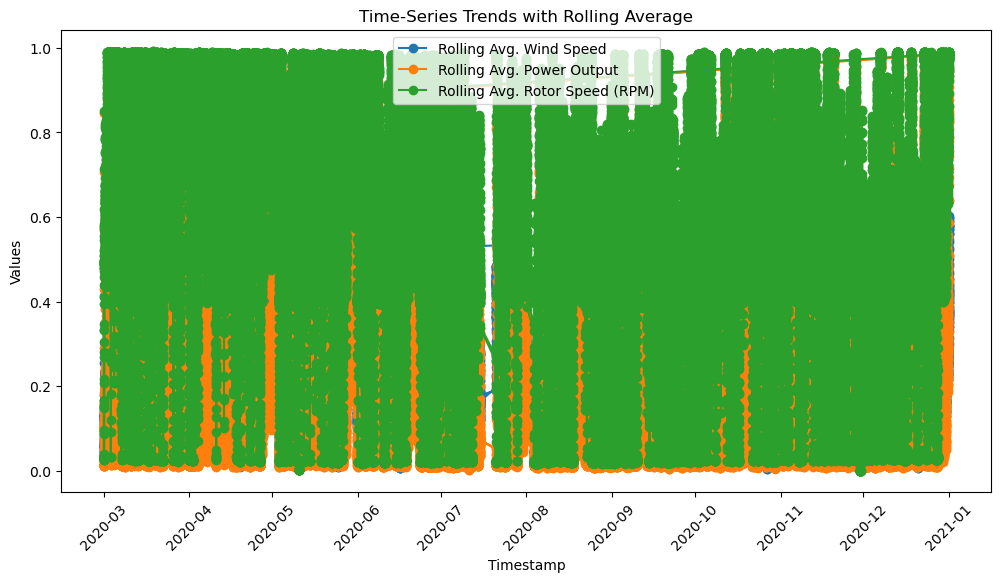

In [19]:
# Calculate rolling averages
df['wind_speed_rolling'] = df['wind_speed'].rolling(window=7).mean()
df['power_output_rolling'] = df['power_output'].rolling(window=7).mean()
df['rotor_speed_rpm_rolling'] = df['rotor_speed_rpm'].rolling(window=7).mean()

# Plot the rolling averages
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['wind_speed_rolling'], label='Rolling Avg. Wind Speed', marker='o')
plt.plot(df['timestamp'], df['power_output_rolling'], label='Rolling Avg. Power Output', marker='o')
plt.plot(df['timestamp'], df['rotor_speed_rpm_rolling'], label='Rolling Avg. Rotor Speed (RPM)', marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Time-Series Trends with Rolling Average')
plt.legend()
plt.xticks(rotation=45)
plt.show()

C:\Users\sharv\AppData\Local\Temp\ipykernel_17700\992558621.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='wind_speed', y='power_output', data=df, style='failure_time_category', palette='viridis')
C:\Users\sharv\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


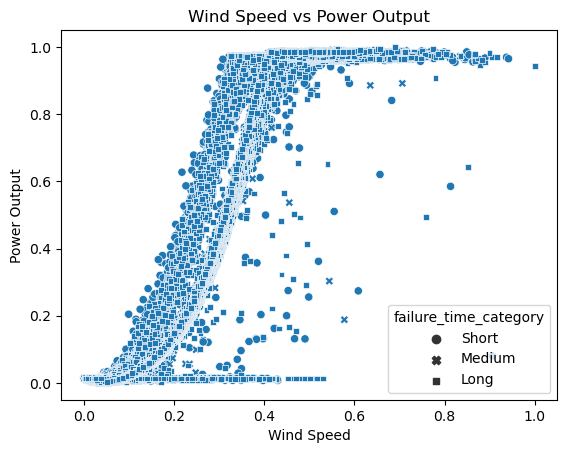

In [20]:
sns.scatterplot(x='wind_speed', y='power_output', data=df, style='failure_time_category', palette='viridis')
plt.title('Wind Speed vs Power Output')
plt.xlabel('Wind Speed')
plt.ylabel('Power Output')
plt.show()

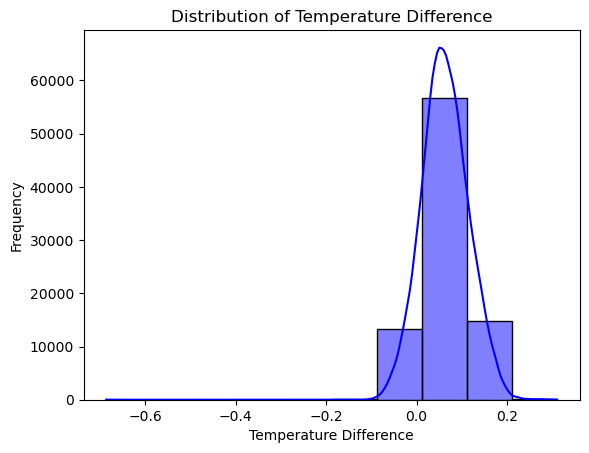

In [21]:
sns.histplot(df['temperature_difference'], kde=True, bins=10, color='blue')
plt.title('Distribution of Temperature Difference')
plt.xlabel('Temperature Difference')
plt.ylabel('Frequency')
plt.show()

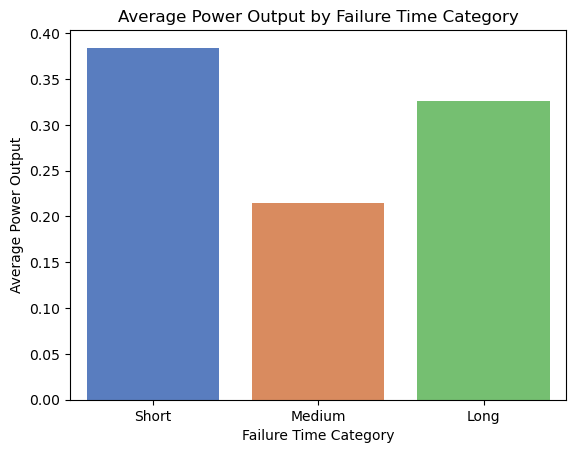

In [22]:
avg_power_by_category = df.groupby('failure_time_category')['power_output'].mean().reset_index()

sns.barplot(x='failure_time_category', y='power_output', data=avg_power_by_category, palette='muted')
plt.title('Average Power Output by Failure Time Category')
plt.xlabel('Failure Time Category')
plt.ylabel('Average Power Output')
plt.show()

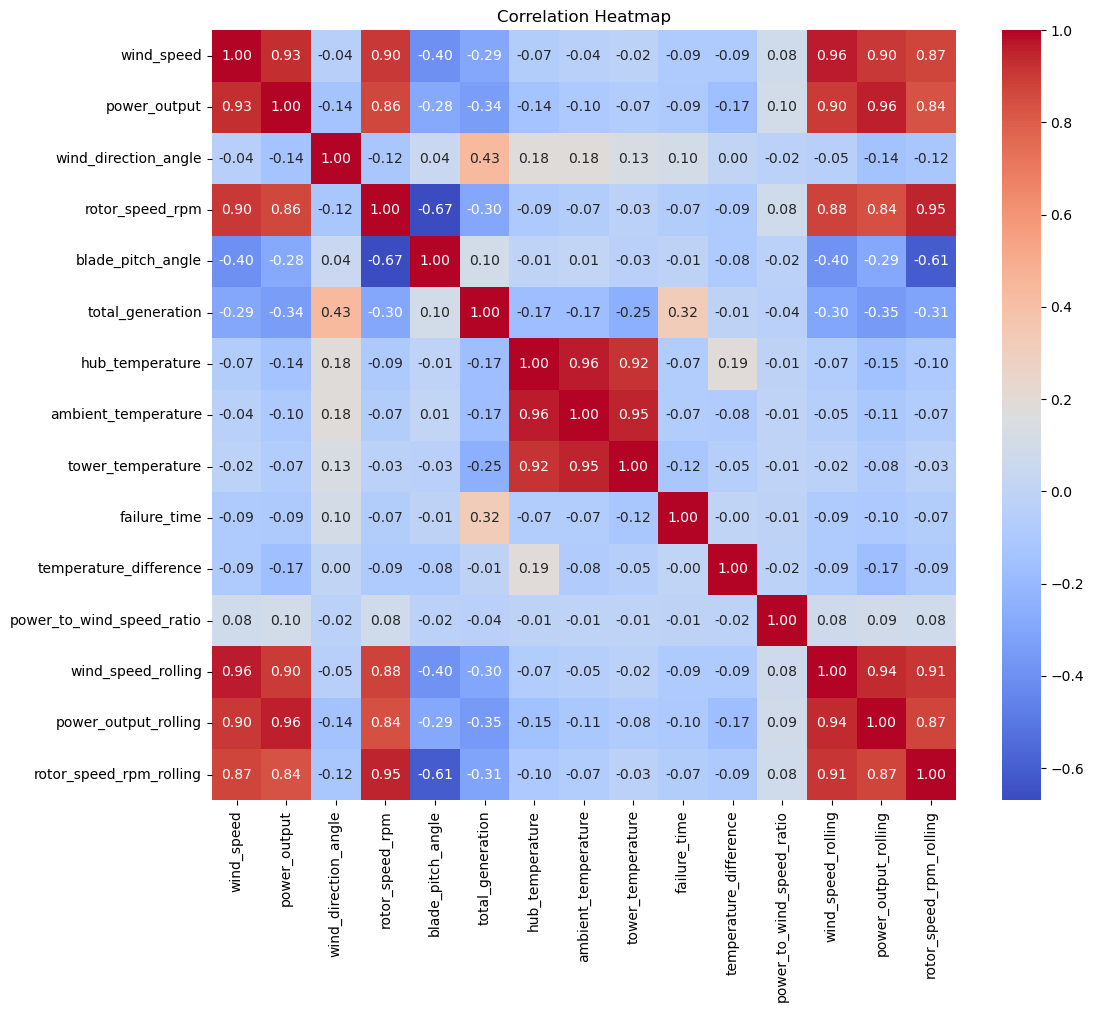

In [23]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

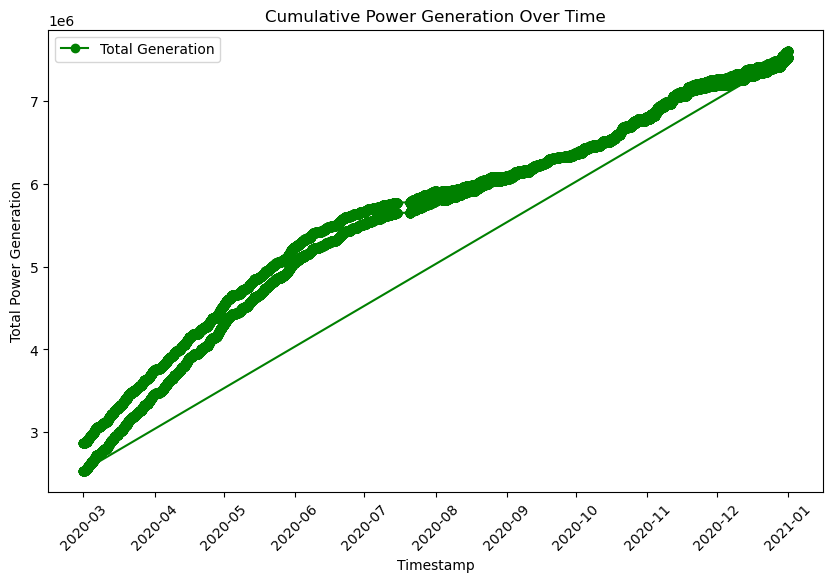

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['total_generation'], label='Total Generation', color='green', marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Total Power Generation')
plt.title('Cumulative Power Generation Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [25]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=fault_type_counts.index, y=fault_type_counts.values, palette='pastel')

for i, count in enumerate(fault_type_counts.values):
    percentage = f'{(count / fault_type_counts.sum()) * 100:.1f}%'
    ax.text(i, count + 1, percentage, ha='center', fontsize=12)

plt.title('Distribution of Fault Types with Percentages', fontsize=16)
plt.xlabel('Fault Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

NameError: name 'fault_type_counts' is not defined

<Figure size 1000x600 with 0 Axes>

C:\Users\sharv\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


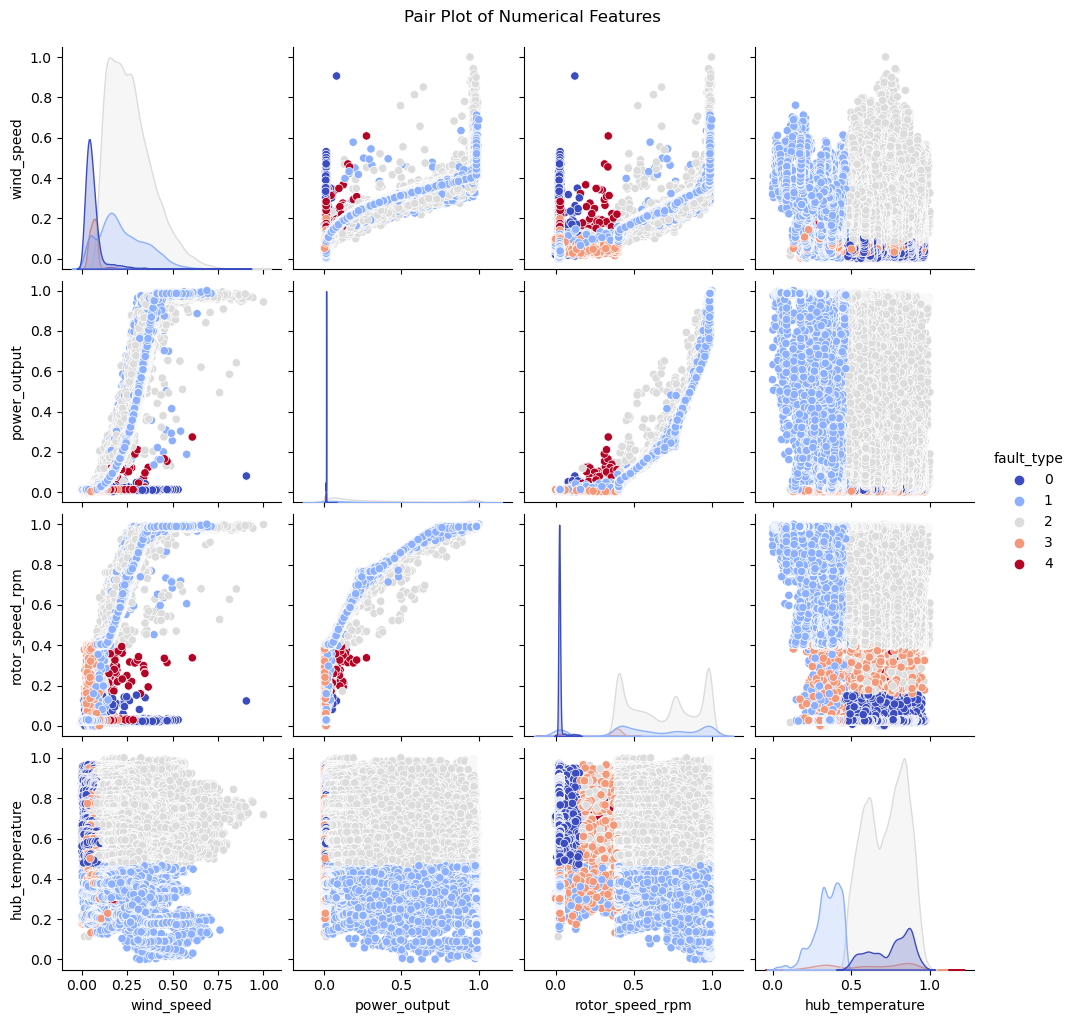

In [26]:
sns.pairplot(df, vars=['wind_speed', 'power_output', 'rotor_speed_rpm', 'hub_temperature'], hue='fault_type', diag_kind='kde', palette='coolwarm')
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

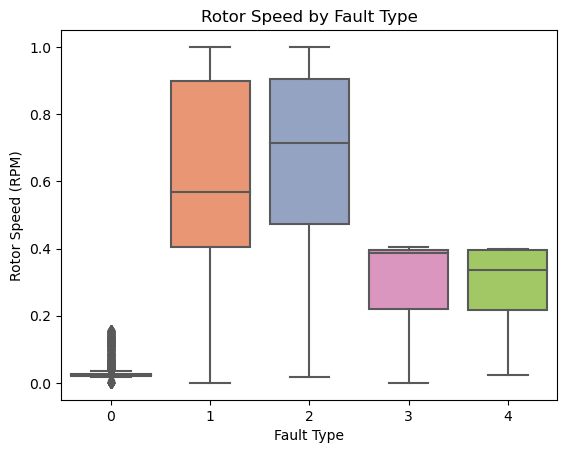

In [27]:
sns.boxplot(x='fault_type', y='rotor_speed_rpm', data=df, palette='Set2')
plt.title('Rotor Speed by Fault Type')
plt.xlabel('Fault Type')
plt.ylabel('Rotor Speed (RPM)')
plt.show()

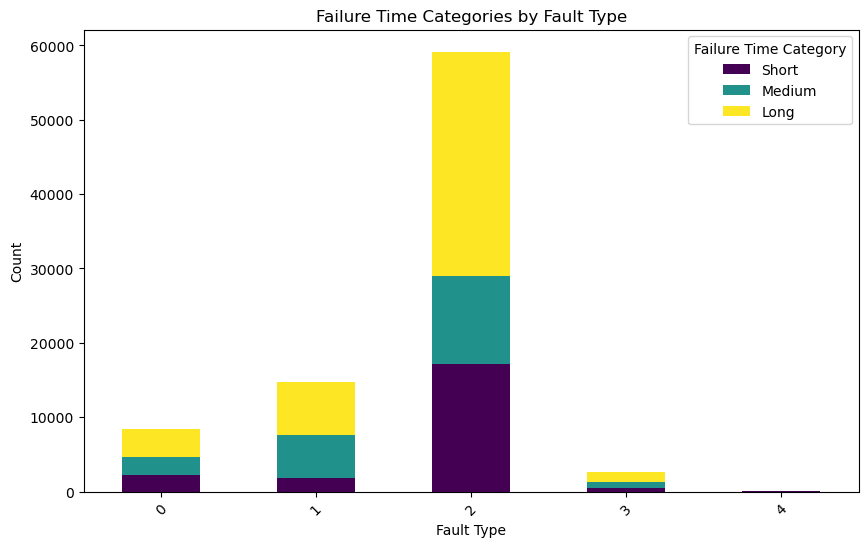

In [28]:
failure_category_counts = df.groupby(['fault_type', 'failure_time_category']).size().unstack()

failure_category_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Failure Time Categories by Fault Type')
plt.xlabel('Fault Type')
plt.ylabel('Count')
plt.legend(title='Failure Time Category')
plt.xticks(rotation=45)
plt.show()

## Training the model

In [29]:
df['failure_time_category'] = LabelEncoder().fit_transform(df['failure_time_category'])

### Random Forest

In [30]:
X = df.drop(columns=['fault_type', 'timestamp'])
y = df['fault_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (68052, 17), Testing set: (17014, 17)


In [31]:
print(X_train.dtypes)

wind_speed                   float64
power_output                 float64
wind_direction_angle         float64
rotor_speed_rpm              float64
blade_pitch_angle            float64
total_generation               int64
hub_temperature              float64
ambient_temperature          float64
tower_temperature            float64
failure_time                 float64
temperature_difference       float64
power_to_wind_speed_ratio    float64
unit_location_WTG40             bool
failure_time_category          int32
wind_speed_rolling           float64
power_output_rolling         float64
rotor_speed_rpm_rolling      float64
dtype: object


In [32]:
X_train['failure_time_category'] = label_encoder.fit_transform(X_train['failure_time_category'])
X_test['failure_time_category'] = label_encoder.transform(X_test['failure_time_category'])

fault_type
2    0.695542
1    0.173512
0    0.099205
3    0.030188
4    0.001552
Name: proportion, dtype: float64


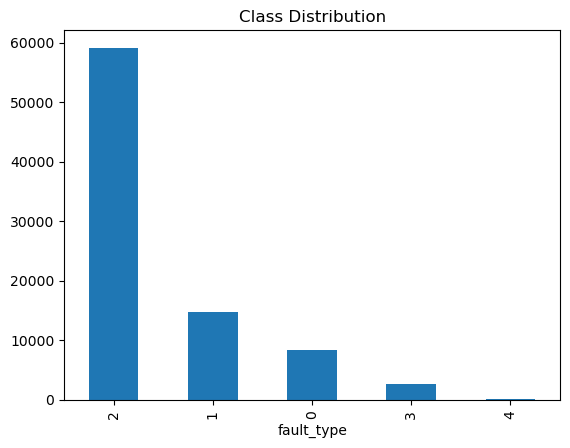

In [33]:
print(df['fault_type'].value_counts(normalize=True))
df['fault_type'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

In [34]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [35]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

rf_model.fit(X_resampled, y_resampled)

y_pred_resampled = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_resampled))

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [47]:
balanced_rf = BalancedRandomForestClassifier(random_state=42)
balanced_rf.fit(X_train, y_train)

y_pred_balanced = balanced_rf.predict(X_test)
print(classification_report(y_test, y_pred_balanced))

C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1682
           1       0.97      0.99      0.98      2994
           2       1.00      0.98      0.99     11811
           3       0.86      0.98      0.92       497
           4       0.28      1.00      0.43        30

    accuracy                           0.99     17014
   macro avg       0.82      0.99      0.86     17014
weighted avg       0.99      0.99      0.99     17014



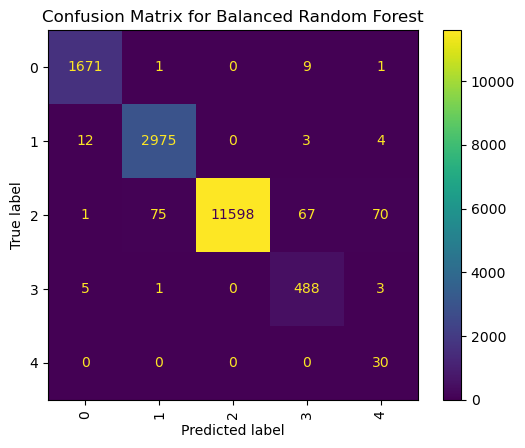

In [48]:
balanced_rm_cm = confusion_matrix(y_test, y_pred_balanced)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=balanced_rm_cm, display_labels=balanced_rf.classes_)
disp.plot(cmap='viridis', xticks_rotation='vertical')

# Add title
plt.title('Confusion Matrix for Balanced Random Forest')
plt.show()

In [50]:
easy_ensemble = EasyEnsembleClassifier(random_state=42)
easy_ensemble.fit(X_train, y_train)

y_pred_easy = easy_ensemble.predict(X_test)
print(classification_report(y_test, y_pred_easy))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1682
           1       0.99      0.99      0.99      2994
           2       1.00      0.99      1.00     11811
           3       0.62      1.00      0.77       497
           4       0.40      1.00      0.57        30

    accuracy                           0.97     17014
   macro avg       0.79      0.96      0.84     17014
weighted avg       0.98      0.97      0.97     17014



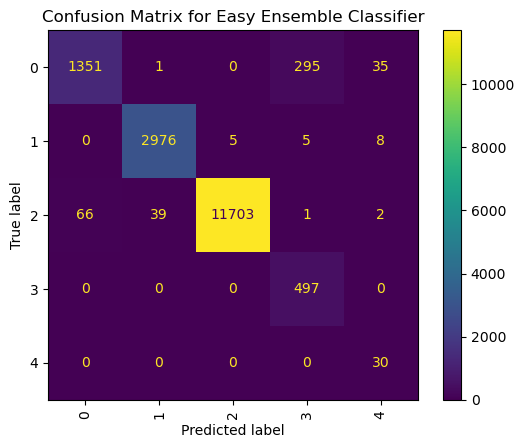

In [51]:
easy_ensemble_cm = confusion_matrix(y_test, y_pred_easy)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=easy_ensemble_cm, display_labels=easy_ensemble.classes_)
disp.plot(cmap='viridis', xticks_rotation='vertical')

# Add title
plt.title('Confusion Matrix for Easy Ensemble Classifier')
plt.show()

In [52]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to test
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_resampled, y_resampled)
print(f"Best Parameters: {random_search.best_params_}")

C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


## LSTM

In [29]:
X_train_lstm = np.expand_dims(X_train, axis=1) 
X_test_lstm = np.expand_dims(X_test, axis=1)   

print(X_train_lstm.shape) 
print(X_test_lstm.shape)

(68052, 1, 14)
(17014, 1, 14)


In [33]:
X_train_lstm = X_train_lstm.astype(np.float32)
X_test_lstm = X_test_lstm.astype(np.float32)

In [37]:
y_train_encoded = to_categorical(y_train, num_classes=5)  # 5 classes
y_test_encoded = to_categorical(y_test, num_classes=5)

In [38]:
scaler = MinMaxScaler()
X_train_lstm = scaler.fit_transform(X_train_lstm.reshape(-1, X_train_lstm.shape[-1])).reshape(X_train_lstm.shape)
X_test_lstm = scaler.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[-1])).reshape(X_test_lstm.shape)

In [39]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')  # 5 classes, use softmax activation
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_lstm, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_encoded)
)

Epoch 1/10


C:\Users\sharv\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2127/2127 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.8360 - loss: 0.5328 - val_accuracy: 0.9494 - val_loss: 0.1348
Epoch 2/10
2127/2127 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.9470 - loss: 0.1538 - val_accuracy: 0.9562 - val_loss: 0.1039
Epoch 3/10
2127/2127 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9558 - loss: 0.1236 - val_accuracy: 0.9654 - val_loss: 0.0849
Epoch 4/10
2127/2127 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9612 - loss: 0.1031 - val_accuracy: 0.9684 - val_loss: 0.0784
Epoch 5/10
2127/2127 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9681 - loss: 0.0876 - val_accuracy: 0.9674 - val_loss: 0.0803
Epoch 6/10
2127/2127 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9699 - loss: 0.0808 - val_accuracy: 0.9791 - val_loss: 0.0599
Epoch 7/10
2127/2127 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9732 - loss: 0.0754 - val_accuracy: 0.9803 - val_loss: 0.0540
Epoch 8/10
2127/2127 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9751 - loss: 0.0668 - v

In [40]:
loss, accuracy = model.evaluate(X_test_lstm, y_test_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9813 - loss: 0.0456
Test Loss: 0.04837501794099808
Test Accuracy: 0.9814270734786987


532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


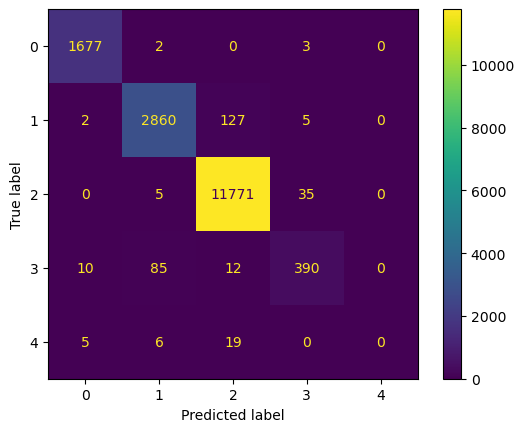

In [43]:
y_pred = model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

lstm_cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap='viridis')
plt.show()

In [44]:
print(classification_report(y_test_classes, y_pred_classes, target_names=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]))

              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99      1682
     Class 1       0.97      0.96      0.96      2994
     Class 2       0.99      1.00      0.99     11811
     Class 3       0.90      0.78      0.84       497
     Class 4       0.00      0.00      0.00        30

    accuracy                           0.98     17014
   macro avg       0.77      0.75      0.76     17014
weighted avg       0.98      0.98      0.98     17014



C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sharv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


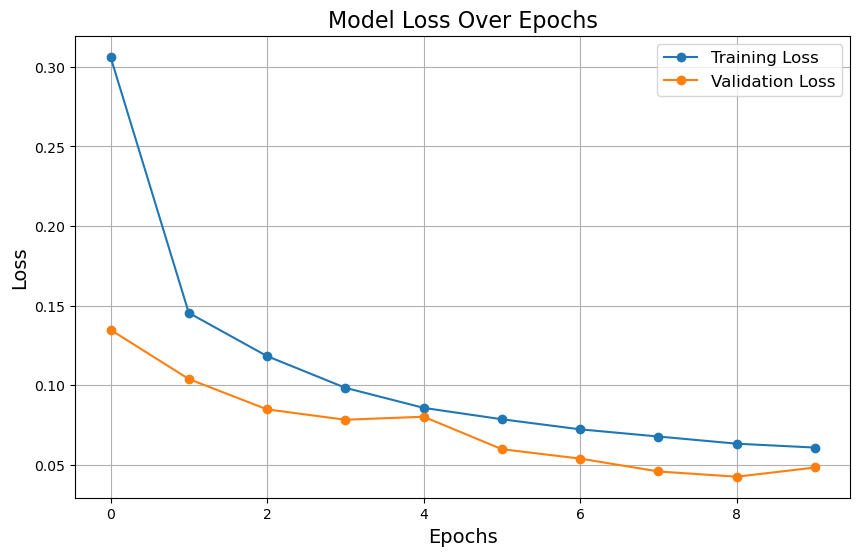

In [45]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True)

plt.show()

In [11]:
import requests
import csv
from datetime import datetime
import time

# Replace with your OpenWeatherMap API key
api_key = "f3ef30343bac9130dc46156d0ccbe4d1"

# List of locations (latitude, longitude, and name)
locations = [
    {"name": "Boulder", "lat": 40.015, "lon": -105.2705},
    {"name": "New York", "lat": 40.7128, "lon": -74.0060},
    {"name": "Los Angeles", "lat": 34.0522, "lon": -118.2437},
    {"name": "Chicago", "lat": 41.8781, "lon": -87.6298},
    {"name": "Houston", "lat": 29.7604, "lon": -95.3698},
    {"name": "Miami", "lat": 25.7617, "lon": -80.1918},
    {"name": "Seattle", "lat": 47.6062, "lon": -122.3321},
    {"name": "Denver", "lat": 39.7392, "lon": -104.9903},
    {"name": "San Francisco", "lat": 37.7749, "lon": -122.4194},
    {"name": "Austin", "lat": 30.2672, "lon": -97.7431},
    {"name": "Boston", "lat": 42.3601, "lon": -71.0589},
    {"name": "Atlanta", "lat": 33.7490, "lon": -84.3880},
    {"name": "Phoenix", "lat": 33.4484, "lon": -112.0740},
    {"name": "San Diego", "lat": 32.7157, "lon": -117.1611},
    {"name": "Las Vegas", "lat": 36.1699, "lon": -115.1398}
]

# File name for saving data
file_name = "wind_data.csv"

with open(file_name, mode='a', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow([
                "Location", "Timestamp", "Wind Speed (m/s)", "Wind Direction (°)", "Temperature (°C)", 
                "Feels Like (°C)", "Pressure (hPa)", "Humidity (%)", "Weather Description", "Cloudinesss",
                "Visibility", "Rain", "Snow", "Sunrise", "Sunset", "Wind Chilli", "Dew Point", "Estimated Power Output (W)"
            ])


# Function to fetch and save data
def fetch_and_save(location):
    url = f"http://api.openweathermap.org/data/2.5/weather?lat={location['lat']}&lon={location['lon']}&appid={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        
        # Extract data
        wind_speed = data['wind']['speed']
        wind_direction = data['wind']['deg']
        temperature = data['main']['temp'] - 273.15
        feels_like = data['main']['feels_like'] - 273.15
        pressure = data['main']['pressure']
        humidity = data['main']['humidity']
        weather_description = data['weather'][0]['description']
        visibility = data.get('visibility', None)
        cloudiness = data['clouds']['all']
        rain_1h = data.get('rain', {}).get('1h', 0)
        snow_1h = data.get('snow', {}).get('1h', 0)
        sunrise = datetime.fromtimestamp(data['sys']['sunrise'])
        sunset = datetime.fromtimestamp(data['sys']['sunset'])
        
        # Derived metrics
        wind_chill = 13.12 + 0.6215 * temperature - 11.37 * (wind_speed * 3.6) ** 0.16 + 0.3965 * temperature * (wind_speed * 3.6) ** 0.16
        wind_chill = round(wind_chill, 2)  # Valid only for cold weather
        dew_point = temperature - ((100 - humidity) / 5)
        
        air_density = 1.225  # kg/m³
        blade_swept_area = 10  # Example value in m²
        power_output = 0.5 * air_density * blade_swept_area * (wind_speed ** 3)
        # Timestamp
        timestamp = datetime.now()
        
        # Print data
        print(
            f"Location: {location['name']}, Timestamp: {timestamp}, Wind Speed: {wind_speed} m/s, "
            f"Wind Direction: {wind_direction}°, Temperature: {temperature:.2f}°C, Feels Like: {feels_like:.2f}°C, "
            f"Pressure: {pressure} hPa, Humidity: {humidity}%, Weather Description: {weather_description}, Cloudiness: {cloudiness}%, "
            f"Visibility: {visibility} m, Rain (1h): {rain_1h} mm, Snow (1h): {snow_1h} mm, "
            f"Sunrise: {sunrise}, Sunset: {sunset}, Wind Chill: {wind_chill}, Dew Point: {dew_point:.2f}°C , Estimated Power Output: {power_output:.2f} W"
        )
        
        # Save to CSV    
        with open(file_name, mode='a', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow([
                location['name'], timestamp, wind_speed, wind_direction, round(temperature, 2), 
                round(feels_like, 2), pressure, humidity, weather_description, cloudiness, visibility, rain_1h, 
                snow_1h, sunrise, sunset, wind_chill, round(dew_point, 2), power_output
            ])
           
try:
    while True:
        for location in locations:
            fetch_and_save(location)
        time.sleep(600)  # Wait 10 minutes before fetching again
except KeyboardInterrupt:
    print("Real-time data fetching stopped.")

Location: Boulder, Timestamp: 2025-01-03 17:41:06.679798, Wind Speed: 0.89 m/s, Wind Direction: 274°, Temperature: 4.09°C, Feels Like: 4.09°C, Pressure: 1018 hPa, Humidity: 49%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:23:07, Sunset: 2025-01-03 16:48:01, Wind Chill: 3.92, Dew Point: -6.11°C , Estimated Power Output: 4.32 W
Location: New York, Timestamp: 2025-01-03 17:41:06.779435, Wind Speed: 5.14 m/s, Wind Direction: 250°, Temperature: 0.44°C, Feels Like: -4.44°C, Pressure: 1009 hPa, Humidity: 65%, Weather Description: few clouds, Cloudiness: 20%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 05:20:09, Sunset: 2025-01-03 14:40:47, Wind Chill: -4.46, Dew Point: -6.56°C , Estimated Power Output: 831.76 W
Location: Los Angeles, Timestamp: 2025-01-03 17:41:06.878540, Wind Speed: 3.09 m/s, Wind Direction: 180°, Temperature: 15.83°C, Feels Like: 15.30°C, Pressure: 1016 hPa, Humi

Location: Seattle, Timestamp: 2025-01-03 17:51:08.817495, Wind Speed: 4.12 m/s, Wind Direction: 130°, Temperature: 7.25°C, Feels Like: 4.56°C, Pressure: 1010 hPa, Humidity: 93%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 08:57:21, Sunset: 2025-01-03 17:30:19, Wind Chill: 4.55, Dew Point: 5.85°C , Estimated Power Output: 428.35 W
Location: Denver, Timestamp: 2025-01-03 17:51:08.928938, Wind Speed: 2.12 m/s, Wind Direction: 7°, Temperature: 4.66°C, Feels Like: 2.85°C, Pressure: 1017 hPa, Humidity: 53%, Weather Description: overcast clouds, Cloudiness: 99%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:21:11, Sunset: 2025-01-03 16:47:42, Wind Chill: 2.83, Dew Point: -4.74°C , Estimated Power Output: 58.36 W
Location: San Francisco, Timestamp: 2025-01-03 17:51:09.073608, Wind Speed: 7.2 m/s, Wind Direction: 270°, Temperature: 12.73°C, Feels Like: 12.25°C, Pressure: 1019 h

Location: Atlanta, Timestamp: 2025-01-03 18:29:48.234866, Wind Speed: 7.2 m/s, Wind Direction: 310°, Temperature: 5.31°C, Feels Like: 0.84°C, Pressure: 1026 hPa, Humidity: 44%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 05:42:41, Sunset: 2025-01-03 15:41:20, Wind Chill: 0.82, Dew Point: -5.89°C , Estimated Power Output: 2286.14 W
Location: Phoenix, Timestamp: 2025-01-03 18:29:48.531156, Wind Speed: 0.89 m/s, Wind Direction: 173°, Temperature: 19.87°C, Feels Like: 18.54°C, Pressure: 1014 hPa, Humidity: 24%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:32:42, Sunset: 2025-01-03 17:32:52, Wind Chill: 21.26, Dew Point: 4.67°C , Estimated Power Output: 4.32 W
Location: San Diego, Timestamp: 2025-01-03 18:29:48.786320, Wind Speed: 3.6 m/s, Wind Direction: 80°, Temperature: 13.53°C, Feels Like: 12.98°C, Pressure: 1016 hPa, Hum

Location: Los Angeles, Timestamp: 2025-01-03 18:51:53.265467, Wind Speed: 6.69 m/s, Wind Direction: 270°, Temperature: 13.50°C, Feels Like: 12.97°C, Pressure: 1017 hPa, Humidity: 79%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:58:53, Sunset: 2025-01-03 17:56:04, Wind Chill: 11.5, Dew Point: 9.30°C , Estimated Power Output: 1833.94 W
Location: Chicago, Timestamp: 2025-01-03 18:51:53.374834, Wind Speed: 6.69 m/s, Wind Direction: 290°, Temperature: -5.67°C, Feels Like: -12.67°C, Pressure: 1027 hPa, Humidity: 63%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 06:18:15, Sunset: 2025-01-03 15:31:43, Wind Chill: -13.06, Dew Point: -13.07°C , Estimated Power Output: 1833.94 W
Location: Houston, Timestamp: 2025-01-03 18:51:53.513863, Wind Speed: 5.14 m/s, Wind Direction: 130°, Temperature: 18.90°C, Feels Like: 18.80°C, Pressure: 1025 hPa

Location: Austin, Timestamp: 2025-01-03 19:01:55.638229, Wind Speed: 0 m/s, Wind Direction: 0°, Temperature: 16.05°C, Feels Like: 15.85°C, Pressure: 1024 hPa, Humidity: 82%, Weather Description: broken clouds, Cloudiness: 75%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 06:27:53, Sunset: 2025-01-03 16:43:00, Wind Chill: 23.1, Dew Point: 12.45°C , Estimated Power Output: 0.00 W
Location: Boston, Timestamp: 2025-01-03 19:01:55.746065, Wind Speed: 6.17 m/s, Wind Direction: 250°, Temperature: -0.71°C, Feels Like: -6.44°C, Pressure: 1006 hPa, Humidity: 57%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 05:13:30, Sunset: 2025-01-03 14:23:51, Wind Chill: -6.46, Dew Point: -9.31°C , Estimated Power Output: 1438.67 W
Location: Atlanta, Timestamp: 2025-01-03 19:01:55.849473, Wind Speed: 7.2 m/s, Wind Direction: 310°, Temperature: 4.88°C, Feels Like: 0.29°C, Pressure: 1027 hPa, Humidity: 45

Location: Las Vegas, Timestamp: 2025-01-03 19:11:57.957918, Wind Speed: 2.57 m/s, Wind Direction: 340°, Temperature: 12.23°C, Feels Like: 10.29°C, Pressure: 1011 hPa, Humidity: 30%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:51:52, Sunset: 2025-01-03 17:38:14, Wind Chill: 11.41, Dew Point: -1.77°C , Estimated Power Output: 103.97 W
Location: Boulder, Timestamp: 2025-01-03 19:21:58.116078, Wind Speed: 3.09 m/s, Wind Direction: 0°, Temperature: 1.18°C, Feels Like: -2.16°C, Pressure: 1018 hPa, Humidity: 60%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:23:07, Sunset: 2025-01-03 16:48:01, Wind Chill: -2.18, Dew Point: -6.82°C , Estimated Power Output: 180.71 W
Location: New York, Timestamp: 2025-01-03 19:21:58.228513, Wind Speed: 6.17 m/s, Wind Direction: 290°, Temperature: 0.08°C, Feels Like: -5.43°C, Pressure: 1008 hPa, Humidi

Location: Miami, Timestamp: 2025-01-03 19:32:00.604751, Wind Speed: 1.54 m/s, Wind Direction: 340°, Temperature: 17.93°C, Feels Like: 17.06°C, Pressure: 1024 hPa, Humidity: 49%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 05:07:55, Sunset: 2025-01-03 15:42:31, Wind Chill: 18.66, Dew Point: 7.73°C , Estimated Power Output: 22.37 W
Location: Seattle, Timestamp: 2025-01-03 19:32:00.714815, Wind Speed: 3.6 m/s, Wind Direction: 140°, Temperature: 6.90°C, Feels Like: 4.41°C, Pressure: 1010 hPa, Humidity: 94%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 08:57:21, Sunset: 2025-01-03 17:30:19, Wind Chill: 4.4, Dew Point: 5.70°C , Estimated Power Output: 285.77 W
Location: Denver, Timestamp: 2025-01-03 19:32:00.813184, Wind Speed: 0.45 m/s, Wind Direction: 0°, Temperature: 2.29°C, Feels Like: 2.29°C, Pressure: 1018 hPa, Humidity: 62

Location: Boston, Timestamp: 2025-01-03 19:45:24.161522, Wind Speed: 6.17 m/s, Wind Direction: 250°, Temperature: -0.83°C, Feels Like: -6.59°C, Pressure: 1005 hPa, Humidity: 57%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 05:13:30, Sunset: 2025-01-03 14:23:51, Wind Chill: -6.61, Dew Point: -9.43°C , Estimated Power Output: 1438.67 W
Location: Atlanta, Timestamp: 2025-01-03 19:45:24.268686, Wind Speed: 6.69 m/s, Wind Direction: 320°, Temperature: 4.02°C, Feels Like: -0.63°C, Pressure: 1027 hPa, Humidity: 43%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 05:42:42, Sunset: 2025-01-03 15:41:20, Wind Chill: -0.65, Dew Point: -7.38°C , Estimated Power Output: 1833.94 W
Location: Phoenix, Timestamp: 2025-01-03 19:45:24.394333, Wind Speed: 0.89 m/s, Wind Direction: 112°, Temperature: 17.66°C, Feels Like: 16.16°C, Pressure: 1014 hPa, Humid

Location: Boulder, Timestamp: 2025-01-03 20:05:26.356304, Wind Speed: 2.06 m/s, Wind Direction: 0°, Temperature: -0.02°C, Feels Like: -2.55°C, Pressure: 1018 hPa, Humidity: 65%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:23:07, Sunset: 2025-01-03 16:48:01, Wind Chill: -2.57, Dew Point: -7.02°C , Estimated Power Output: 53.54 W
Location: New York, Timestamp: 2025-01-03 20:05:26.477394, Wind Speed: 5.14 m/s, Wind Direction: 270°, Temperature: -0.25°C, Feels Like: -5.31°C, Pressure: 1008 hPa, Humidity: 67%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 05:20:09, Sunset: 2025-01-03 14:40:47, Wind Chill: -5.33, Dew Point: -6.85°C , Estimated Power Output: 831.76 W
Location: Los Angeles, Timestamp: 2025-01-03 20:05:26.603851, Wind Speed: 3.09 m/s, Wind Direction: 180°, Temperature: 12.48°C, Feels Like: 11.98°C, Pressure: 1018 hPa, Hum

Location: Seattle, Timestamp: 2025-01-03 20:15:28.915784, Wind Speed: 3.13 m/s, Wind Direction: 102°, Temperature: 6.96°C, Feels Like: 4.77°C, Pressure: 1010 hPa, Humidity: 94%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 08:57:21, Sunset: 2025-01-03 17:30:19, Wind Chill: 4.76, Dew Point: 5.76°C , Estimated Power Output: 187.82 W
Location: Denver, Timestamp: 2025-01-03 20:15:29.028491, Wind Speed: 1.42 m/s, Wind Direction: 19°, Temperature: 1.46°C, Feels Like: 0.03°C, Pressure: 1018 hPa, Humidity: 66%, Weather Description: overcast clouds, Cloudiness: 98%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:21:11, Sunset: 2025-01-03 16:47:42, Wind Chill: 0.02, Dew Point: -5.34°C , Estimated Power Output: 17.54 W
Location: San Francisco, Timestamp: 2025-01-03 20:15:29.140669, Wind Speed: 5.81 m/s, Wind Direction: 286°, Temperature: 11.34°C, Feels Like: 10.78°C, Pressure: 1021

Location: Phoenix, Timestamp: 2025-01-03 20:25:31.634946, Wind Speed: 0 m/s, Wind Direction: 0°, Temperature: 18.36°C, Feels Like: 16.80°C, Pressure: 1014 hPa, Humidity: 21%, Weather Description: broken clouds, Cloudiness: 75%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:32:42, Sunset: 2025-01-03 17:32:52, Wind Chill: 24.53, Dew Point: 2.56°C , Estimated Power Output: 0.00 W
Location: San Diego, Timestamp: 2025-01-03 20:25:31.788278, Wind Speed: 2.68 m/s, Wind Direction: 151°, Temperature: 12.36°C, Feels Like: 11.79°C, Pressure: 1017 hPa, Humidity: 82%, Weather Description: haze, Cloudiness: 20%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:51:17, Sunset: 2025-01-03 17:55:00, Wind Chill: 11.5, Dew Point: 8.76°C , Estimated Power Output: 117.90 W
Location: Las Vegas, Timestamp: 2025-01-03 20:25:31.893316, Wind Speed: 2.57 m/s, Wind Direction: 60°, Temperature: 11.36°C, Feels Like: 9.36°C, Pressure: 1011 hPa, Humidity: 31

Location: Los Angeles, Timestamp: 2025-01-03 20:45:34.475856, Wind Speed: 4.12 m/s, Wind Direction: 250°, Temperature: 12.50°C, Feels Like: 11.92°C, Pressure: 1018 hPa, Humidity: 81%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:58:53, Sunset: 2025-01-03 17:56:04, Wind Chill: 11.01, Dew Point: 8.70°C , Estimated Power Output: 428.35 W
Location: Chicago, Timestamp: 2025-01-03 20:45:34.654183, Wind Speed: 4.63 m/s, Wind Direction: 290°, Temperature: -6.30°C, Feels Like: -12.53°C, Pressure: 1027 hPa, Humidity: 61%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 06:18:15, Sunset: 2025-01-03 15:31:43, Wind Chill: -12.55, Dew Point: -14.10°C , Estimated Power Output: 607.92 W
Location: Houston, Timestamp: 2025-01-03 20:45:34.811378, Wind Speed: 4.12 m/s, Wind Direction: 140°, Temperature: 17.84°C, Feels Like: 17.69°C, Pressure: 1025 hPa,

Location: Denver, Timestamp: 2025-01-03 21:52:54.060001, Wind Speed: 0.45 m/s, Wind Direction: 34°, Temperature: 0.06°C, Feels Like: 0.06°C, Pressure: 1017 hPa, Humidity: 72%, Weather Description: broken clouds, Cloudiness: 81%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:21:11, Sunset: 2025-01-03 16:47:42, Wind Chill: 0.9, Dew Point: -5.54°C , Estimated Power Output: 0.56 W
Location: San Francisco, Timestamp: 2025-01-03 21:52:54.277561, Wind Speed: 3.6 m/s, Wind Direction: 240°, Temperature: 10.95°C, Feels Like: 10.40°C, Pressure: 1021 hPa, Humidity: 88%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 08:25:19, Sunset: 2025-01-03 18:03:03, Wind Chill: 9.34, Dew Point: 8.55°C , Estimated Power Output: 285.77 W
Location: Austin, Timestamp: 2025-01-03 21:52:54.493788, Wind Speed: 0 m/s, Wind Direction: 0°, Temperature: 15.45°C, Feels Like: 15.27°C, Pressure: 1023 hPa, Humidity: 8

Location: Phoenix, Timestamp: 2025-01-03 22:02:57.149746, Wind Speed: 0.57 m/s, Wind Direction: 189°, Temperature: 16.49°C, Feels Like: 14.82°C, Pressure: 1014 hPa, Humidity: 24%, Weather Description: overcast clouds, Cloudiness: 99%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:32:42, Sunset: 2025-01-03 17:32:52, Wind Chill: 17.95, Dew Point: 1.29°C , Estimated Power Output: 1.13 W
Location: San Diego, Timestamp: 2025-01-03 22:02:57.246503, Wind Speed: 1.34 m/s, Wind Direction: 282°, Temperature: 11.51°C, Feels Like: 11.04°C, Pressure: 1019 hPa, Humidity: 89%, Weather Description: haze, Cloudiness: 75%, Visibility: 8047 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:51:17, Sunset: 2025-01-03 17:55:00, Wind Chill: 11.52, Dew Point: 9.31°C , Estimated Power Output: 14.74 W
Location: Las Vegas, Timestamp: 2025-01-03 22:02:57.362862, Wind Speed: 1.54 m/s, Wind Direction: 220°, Temperature: 11.06°C, Feels Like: 9.14°C, Pressure: 1010 hPa, Humid

Location: Los Angeles, Timestamp: 2025-01-03 23:33:34.360964, Wind Speed: 3.09 m/s, Wind Direction: 110°, Temperature: 11.35°C, Feels Like: 10.79°C, Pressure: 1018 hPa, Humidity: 86%, Weather Description: mist, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:58:53, Sunset: 2025-01-03 17:56:04, Wind Chill: 10.07, Dew Point: 8.55°C , Estimated Power Output: 180.71 W
Location: Chicago, Timestamp: 2025-01-03 23:33:34.500825, Wind Speed: 3.13 m/s, Wind Direction: 354°, Temperature: -7.88°C, Feels Like: -13.11°C, Pressure: 1028 hPa, Humidity: 62%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 06:18:14, Sunset: 2025-01-04 15:32:37, Wind Chill: -13.13, Dew Point: -15.48°C , Estimated Power Output: 187.82 W
Location: Houston, Timestamp: 2025-01-03 23:33:34.639327, Wind Speed: 4.63 m/s, Wind Direction: 110°, Temperature: 17.59°C, Feels Like: 17.44°C, Pressure: 1024 hPa, Hu

Location: Denver, Timestamp: 2025-01-03 23:43:37.425434, Wind Speed: 1.5 m/s, Wind Direction: 10°, Temperature: -0.17°C, Feels Like: -1.95°C, Pressure: 1016 hPa, Humidity: 73%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:21:11, Sunset: 2025-01-03 16:47:42, Wind Chill: -1.97, Dew Point: -5.57°C , Estimated Power Output: 20.67 W
Location: San Francisco, Timestamp: 2025-01-03 23:43:37.571899, Wind Speed: 1.34 m/s, Wind Direction: 269°, Temperature: 10.56°C, Feels Like: 9.97°C, Pressure: 1022 hPa, Humidity: 88%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 08:25:19, Sunset: 2025-01-03 18:03:03, Wind Chill: 10.44, Dew Point: 8.16°C , Estimated Power Output: 14.74 W
Location: Austin, Timestamp: 2025-01-03 23:43:37.724302, Wind Speed: 2.57 m/s, Wind Direction: 150°, Temperature: 15.63°C, Feels Like: 15.52°C, Pressure: 1

Location: Phoenix, Timestamp: 2025-01-03 23:53:40.113847, Wind Speed: 2.06 m/s, Wind Direction: 90°, Temperature: 15.71°C, Feels Like: 14.07°C, Pressure: 1013 hPa, Humidity: 28%, Weather Description: broken clouds, Cloudiness: 75%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:32:42, Sunset: 2025-01-03 17:32:52, Wind Chill: 15.8, Dew Point: 1.31°C , Estimated Power Output: 53.54 W
Location: San Diego, Timestamp: 2025-01-03 23:53:40.334215, Wind Speed: 2.57 m/s, Wind Direction: 60°, Temperature: 10.93°C, Feels Like: 10.43°C, Pressure: 1018 hPa, Humidity: 90%, Weather Description: haze, Cloudiness: 75%, Visibility: 8047 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:51:17, Sunset: 2025-01-03 17:55:00, Wind Chill: 9.87, Dew Point: 8.93°C , Estimated Power Output: 103.97 W
Location: Las Vegas, Timestamp: 2025-01-03 23:53:40.455519, Wind Speed: 1.54 m/s, Wind Direction: 0°, Temperature: 10.62°C, Feels Like: 8.55°C, Pressure: 1010 hPa, Humidity: 3

Location: Los Angeles, Timestamp: 2025-01-04 00:13:42.761040, Wind Speed: 2.06 m/s, Wind Direction: 130°, Temperature: 11.41°C, Feels Like: 10.85°C, Pressure: 1018 hPa, Humidity: 86%, Weather Description: mist, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:58:53, Sunset: 2025-01-03 17:56:04, Wind Chill: 10.78, Dew Point: 8.61°C , Estimated Power Output: 53.54 W
Location: Chicago, Timestamp: 2025-01-04 00:13:42.876114, Wind Speed: 4.12 m/s, Wind Direction: 290°, Temperature: -8.25°C, Feels Like: -14.53°C, Pressure: 1027 hPa, Humidity: 65%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 06:18:14, Sunset: 2025-01-04 15:32:37, Wind Chill: -14.55, Dew Point: -15.25°C , Estimated Power Output: 428.35 W
Location: Houston, Timestamp: 2025-01-04 00:13:42.979286, Wind Speed: 5.66 m/s, Wind Direction: 130°, Temperature: 17.40°C, Feels Like: 17.26°C, Pressure: 1024 hPa, Hum

Location: San Francisco, Timestamp: 2025-01-04 00:23:45.446495, Wind Speed: 2.57 m/s, Wind Direction: 150°, Temperature: 10.25°C, Feels Like: 9.65°C, Pressure: 1022 hPa, Humidity: 89%, Weather Description: few clouds, Cloudiness: 20%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 08:25:19, Sunset: 2025-01-03 18:03:03, Wind Chill: 9.06, Dew Point: 8.05°C , Estimated Power Output: 103.97 W
Location: Austin, Timestamp: 2025-01-04 00:23:45.571617, Wind Speed: 3.09 m/s, Wind Direction: 180°, Temperature: 16.01°C, Feels Like: 15.89°C, Pressure: 1022 hPa, Humidity: 85%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 06:28:03, Sunset: 2025-01-04 16:43:44, Wind Chill: 15.69, Dew Point: 13.01°C , Estimated Power Output: 180.71 W
Location: Boston, Timestamp: 2025-01-04 00:23:45.700312, Wind Speed: 7.2 m/s, Wind Direction: 270°, Temperature: -2.40°C, Feels Like: -9.09°C, Pressure: 1003 

Location: Las Vegas, Timestamp: 2025-01-04 00:33:47.940247, Wind Speed: 5.14 m/s, Wind Direction: 230°, Temperature: 14.49°C, Feels Like: 12.49°C, Pressure: 1010 hPa, Humidity: 19%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-03 07:51:52, Sunset: 2025-01-03 17:38:14, Wind Chill: 13.15, Dew Point: -1.71°C , Estimated Power Output: 831.76 W
Location: Boulder, Timestamp: 2025-01-04 13:50:05.691620, Wind Speed: 1.85 m/s, Wind Direction: 99°, Temperature: 9.60°C, Feels Like: 8.85°C, Pressure: 1001 hPa, Humidity: 33%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 07:23:07, Sunset: 2025-01-04 16:48:54, Wind Chill: 8.84, Dew Point: -3.80°C , Estimated Power Output: 38.78 W
Location: New York, Timestamp: 2025-01-04 13:50:05.832223, Wind Speed: 13.89 m/s, Wind Direction: 310°, Temperature: -0.06°C, Feels Like: -7.06°C, Pressure: 1012 hPa, Humidi

Location: Houston, Timestamp: 2025-01-04 14:11:43.926973, Wind Speed: 7.2 m/s, Wind Direction: 130°, Temperature: 20.77°C, Feels Like: 21.10°C, Pressure: 1017 hPa, Humidity: 84%, Weather Description: mist, Cloudiness: 100%, Visibility: 9656 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 06:17:25, Sunset: 2025-01-04 16:35:23, Wind Chill: 20.75, Dew Point: 17.57°C , Estimated Power Output: 2286.14 W
Location: Miami, Timestamp: 2025-01-04 14:11:44.030595, Wind Speed: 6.17 m/s, Wind Direction: 40°, Temperature: 21.26°C, Feels Like: 21.06°C, Pressure: 1023 hPa, Humidity: 62%, Weather Description: few clouds, Cloudiness: 20%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 05:08:07, Sunset: 2025-01-04 15:43:12, Wind Chill: 21.5, Dew Point: 13.66°C , Estimated Power Output: 1438.67 W
Location: Seattle, Timestamp: 2025-01-04 14:11:44.140161, Wind Speed: 1.54 m/s, Wind Direction: 140°, Temperature: 7.67°C, Feels Like: 6.95°C, Pressure: 1016 hPa, Humidity: 92

Location: Austin, Timestamp: 2025-01-04 14:23:48.651619, Wind Speed: 2.57 m/s, Wind Direction: 150°, Temperature: 20.61°C, Feels Like: 20.87°C, Pressure: 1015 hPa, Humidity: 82%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 06:28:03, Sunset: 2025-01-04 16:43:44, Wind Chill: 21.36, Dew Point: 17.01°C , Estimated Power Output: 103.97 W
Location: Boston, Timestamp: 2025-01-04 14:23:48.769536, Wind Speed: 7.72 m/s, Wind Direction: 300°, Temperature: -2.18°C, Feels Like: -9.04°C, Pressure: 1006 hPa, Humidity: 48%, Weather Description: scattered clouds, Cloudiness: 40%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 05:13:29, Sunset: 2025-01-04 14:24:48, Wind Chill: -9.06, Dew Point: -12.58°C , Estimated Power Output: 2818.11 W
Location: Atlanta, Timestamp: 2025-01-04 14:23:48.882025, Wind Speed: 4.63 m/s, Wind Direction: 300°, Temperature: 7.01°C, Feels Like: 4.02°C, Pressure: 1

Location: Las Vegas, Timestamp: 2025-01-04 15:27:05.303391, Wind Speed: 6.69 m/s, Wind Direction: 340°, Temperature: 17.12°C, Feels Like: 15.36°C, Pressure: 1016 hPa, Humidity: 18%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 07:51:56, Sunset: 2025-01-04 17:39:03, Wind Chill: 16.14, Dew Point: 0.72°C , Estimated Power Output: 1833.94 W
Location: Boulder, Timestamp: 2025-01-04 15:37:05.442551, Wind Speed: 3.6 m/s, Wind Direction: 20°, Temperature: 4.48°C, Feels Like: 1.47°C, Pressure: 1007 hPa, Humidity: 64%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 07:23:07, Sunset: 2025-01-04 16:48:54, Wind Chill: 1.45, Dew Point: -2.72°C , Estimated Power Output: 285.77 W
Location: New York, Timestamp: 2025-01-04 15:37:05.553537, Wind Speed: 10.29 m/s, Wind Direction: 300°, Temperature: -0.59°C, Feels Like: -7.59°C, Pressure: 1013 hPa

Location: Houston, Timestamp: 2025-01-04 15:47:09.378965, Wind Speed: 4.63 m/s, Wind Direction: 110°, Temperature: 20.77°C, Feels Like: 21.15°C, Pressure: 1016 hPa, Humidity: 86%, Weather Description: mist, Cloudiness: 100%, Visibility: 6437 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 06:17:25, Sunset: 2025-01-04 16:35:23, Wind Chill: 21.11, Dew Point: 17.97°C , Estimated Power Output: 607.92 W
Location: Miami, Timestamp: 2025-01-04 15:47:10.291187, Wind Speed: 5.14 m/s, Wind Direction: 50°, Temperature: 19.56°C, Feels Like: 19.32°C, Pressure: 1023 hPa, Humidity: 67%, Weather Description: scattered clouds, Cloudiness: 40%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 05:08:07, Sunset: 2025-01-04 15:43:12, Wind Chill: 19.51, Dew Point: 12.96°C , Estimated Power Output: 831.76 W
Location: Seattle, Timestamp: 2025-01-04 15:47:10.460112, Wind Speed: 4.47 m/s, Wind Direction: 135°, Temperature: 7.61°C, Feels Like: 4.84°C, Pressure: 1016 hPa, Humidi

Location: Austin, Timestamp: 2025-01-04 15:57:19.969855, Wind Speed: 5.66 m/s, Wind Direction: 180°, Temperature: 21.69°C, Feels Like: 21.98°C, Pressure: 1014 hPa, Humidity: 79%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 06:28:03, Sunset: 2025-01-04 16:43:44, Wind Chill: 22.11, Dew Point: 17.49°C , Estimated Power Output: 1110.59 W
Location: Boston, Timestamp: 2025-01-04 15:57:20.112229, Wind Speed: 7.72 m/s, Wind Direction: 280°, Temperature: -2.68°C, Feels Like: -9.68°C, Pressure: 1007 hPa, Humidity: 52%, Weather Description: few clouds, Cloudiness: 20%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 05:13:28, Sunset: 2025-01-04 14:24:46, Wind Chill: -9.71, Dew Point: -12.28°C , Estimated Power Output: 2818.11 W
Location: Atlanta, Timestamp: 2025-01-04 15:57:20.418373, Wind Speed: 5.14 m/s, Wind Direction: 310°, Temperature: 5.64°C, Feels Like: 2.07°C, Pressure: 1026 h

Location: Boulder, Timestamp: 2025-01-04 16:17:23.558345, Wind Speed: 2.22 m/s, Wind Direction: 53°, Temperature: 5.70°C, Feels Like: 3.97°C, Pressure: 1007 hPa, Humidity: 56%, Weather Description: scattered clouds, Cloudiness: 31%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 07:23:07, Sunset: 2025-01-04 16:48:54, Wind Chill: 3.96, Dew Point: -3.10°C , Estimated Power Output: 67.01 W
Location: New York, Timestamp: 2025-01-04 16:17:23.699157, Wind Speed: 8.23 m/s, Wind Direction: 280°, Temperature: -0.69°C, Feels Like: -7.31°C, Pressure: 1014 hPa, Humidity: 39%, Weather Description: scattered clouds, Cloudiness: 40%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 05:20:09, Sunset: 2025-01-04 14:41:41, Wind Chill: -7.33, Dew Point: -12.89°C , Estimated Power Output: 3414.33 W
Location: Los Angeles, Timestamp: 2025-01-04 16:17:23.796204, Wind Speed: 3.6 m/s, Wind Direction: 250°, Temperature: 16.43°C, Feels Like: 15.80°C, Pressure

Location: Seattle, Timestamp: 2025-01-04 16:27:26.241297, Wind Speed: 4.12 m/s, Wind Direction: 140°, Temperature: 7.72°C, Feels Like: 5.14°C, Pressure: 1016 hPa, Humidity: 93%, Weather Description: moderate rain, Cloudiness: 100%, Visibility: 8047 m, Rain (1h): 2.05 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 08:57:12, Sunset: 2025-01-04 17:31:22, Wind Chill: 5.13, Dew Point: 6.32°C , Estimated Power Output: 428.35 W
Location: Denver, Timestamp: 2025-01-04 16:27:26.342638, Wind Speed: 3.41 m/s, Wind Direction: 14°, Temperature: -4.10°C, Feels Like: -8.82°C, Pressure: 1005 hPa, Humidity: 41%, Weather Description: few clouds, Cloudiness: 21%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 07:21:12, Sunset: 2025-01-04 16:48:35, Wind Chill: -8.84, Dew Point: -15.90°C , Estimated Power Output: 242.87 W
Location: San Francisco, Timestamp: 2025-01-04 16:27:26.471665, Wind Speed: 1.79 m/s, Wind Direction: 274°, Temperature: 12.37°C, Feels Like: 11.78°C, Pressure: 1024

Location: Atlanta, Timestamp: 2025-01-04 16:37:28.505170, Wind Speed: 4.12 m/s, Wind Direction: 330°, Temperature: 4.38°C, Feels Like: 1.03°C, Pressure: 1027 hPa, Humidity: 40%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 05:42:48, Sunset: 2025-01-04 15:42:06, Wind Chill: 1.01, Dew Point: -7.62°C , Estimated Power Output: 428.35 W
Location: Phoenix, Timestamp: 2025-01-04 16:37:28.600054, Wind Speed: 2.68 m/s, Wind Direction: 255°, Temperature: 20.55°C, Feels Like: 19.16°C, Pressure: 1013 hPa, Humidity: 19%, Weather Description: broken clouds, Cloudiness: 82%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 07:32:49, Sunset: 2025-01-04 17:33:39, Wind Chill: 21.26, Dew Point: 4.35°C , Estimated Power Output: 117.90 W
Location: San Diego, Timestamp: 2025-01-04 16:37:28.702292, Wind Speed: 4.63 m/s, Wind Direction: 310°, Temperature: 15.53°C, Feels Like: 14.94°C, Pressure: 1017 hPa, Hu

Location: Los Angeles, Timestamp: 2025-01-04 16:57:30.994144, Wind Speed: 3.6 m/s, Wind Direction: 250°, Temperature: 15.89°C, Feels Like: 15.26°C, Pressure: 1017 hPa, Humidity: 66%, Weather Description: clear sky, Cloudiness: 0%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 07:58:59, Sunset: 2025-01-04 17:56:51, Wind Chill: 15.36, Dew Point: 9.09°C , Estimated Power Output: 285.77 W
Location: Chicago, Timestamp: 2025-01-04 16:57:31.115890, Wind Speed: 3.09 m/s, Wind Direction: 300°, Temperature: -5.73°C, Feels Like: -10.48°C, Pressure: 1027 hPa, Humidity: 49%, Weather Description: broken clouds, Cloudiness: 75%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 06:18:14, Sunset: 2025-01-04 15:32:37, Wind Chill: -10.5, Dew Point: -15.93°C , Estimated Power Output: 180.71 W
Location: Houston, Timestamp: 2025-01-04 16:57:31.244112, Wind Speed: 8.23 m/s, Wind Direction: 130°, Temperature: 20.49°C, Feels Like: 20.87°C, Pressure: 1016 h

Location: San Francisco, Timestamp: 2025-01-04 17:07:33.488283, Wind Speed: 2.68 m/s, Wind Direction: 305°, Temperature: 11.96°C, Feels Like: 11.38°C, Pressure: 1024 hPa, Humidity: 83%, Weather Description: broken clouds, Cloudiness: 75%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 08:25:21, Sunset: 2025-01-04 18:03:54, Wind Chill: 11.03, Dew Point: 8.56°C , Estimated Power Output: 117.90 W
Location: Austin, Timestamp: 2025-01-04 17:07:33.605204, Wind Speed: 3.6 m/s, Wind Direction: 170°, Temperature: 21.43°C, Feels Like: 21.74°C, Pressure: 1014 hPa, Humidity: 81%, Weather Description: overcast clouds, Cloudiness: 100%, Visibility: 10000 m, Rain (1h): 0 mm, Snow (1h): 0 mm, Sunrise: 2025-01-04 06:28:03, Sunset: 2025-01-04 16:43:44, Wind Chill: 22.11, Dew Point: 17.63°C , Estimated Power Output: 285.77 W
Location: Boston, Timestamp: 2025-01-04 17:07:33.700510, Wind Speed: 6.17 m/s, Wind Direction: 280°, Temperature: -2.44°C, Feels Like: -8.64°C, Pressure: 